# AIAP Batch 15 Technical Assessment
*written by Billy Lim Jun Ming*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import Levenshtein

import src.datapipeline

pd.set_option('display.max_column', None)

## 0. Data Reading
<sub>We were instructed to remove the SQL databases from our submission, so you have to add them back before re-running this ipynb.</sub>  

There are two SQL databases provided, in `./data/cruise_pre.db` and `./data/cruise_post.db`.
The description of the attributes in each of these databases are provided in the 

In [2]:
# read pre data
con_pre = sqlite3.connect("data/cruise_pre.db")
df_pre = pd.read_sql('SELECT * FROM cruise_pre', con_pre)
con_pre.close()
df_pre.head()

,index,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Ext_Intcode
0,0,None,05/10/1973,Direct - Company Website,A little important,3.0,5.0,3.0,01/01/2023 0:00,Very important,2.0,2.0,A little important,2.0,2.0,4.0,2.0,3.0,LB446RWOOZI
1,1,Female,None,Indirect - Social Media,Not at all important,4.0,1.0,NaN,01/01/2023 0:01,Very important,NaN,4.0,None,2.0,3.0,4.0,4.0,4.0,LB138HKBECM
2,2,Female,22/07/1998,Indirect - Search Engine,None,3.0,0.0,5.0,01/01/2023 0:02,None,NaN,5.0,Extremely important,2.0,1.0,2.0,3.0,NaN,BL713UHBAAN
3,3,Female,01/05/1970,Direct - Company Website,Very important,4.0,4.0,4.0,01/01/2023 0:05,Somewhat important,4.0,4.0,None,NaN,NaN,3.0,2.0,4.0,LB243DMKCFL
4,4,Male,07/01/1960,Direct - Company Website,Somewhat important,4.0,2.0,NaN,01/01/2023 0:06,Not at all important,2.0,NaN,Not at all important,3.0,NaN,5.0,2.0,NaN,LB218CFLOBS


In [3]:
# read post_data
con_post = sqlite3.connect("data/cruise_post.db")
df_post = pd.read_sql('SELECT * FROM cruise_post', con_post)
con_post.close()
df_post.head()

,index,Cruise Name,Ticket Type,Cruise Distance,Ext_Intcode,WiFi,Dining,Entertainment
0,0,Blastoise,None,3567 KM,LB446RWOOZI,1.0,1,1.0
1,1,Blastoise,Deluxe,672 KM,LB138HKBECM,NaN,0,1.0
2,2,IAPRAS,Deluxe,1167 KM,BL713UHBAAN,NaN,0,0.0
3,3,Lapras,Deluxe,280 KM,LB243DMKCFL,NaN,0,1.0
4,4,Lapras,Standard,1145 Miles,LB218CFLOBS,NaN,1,NaN


## 1. Data Cleaning
In this section, I'll clean the SQL database, correcting any typos, changing the data types to better suit the column, etc.  

These data cleaning steps will be replicated in the final ML pipeline, since I don't have access to the copy of the database that will used in production.  

### 1.1. Duplicate Ext_Intcode
We want to use `Ext_Intcode` as the index, since it should be unique for each passenger.  

But it appears that several `Ext_Intcode` are duplicated across multiple rows in the database.  
Visual insepction reveals that these rows and mostly identical, with `Logging` columns that are too close to indicate repeat passengers.  
So, we'll drop these rows with duplicated `Ext_Intcode`, only keeping the row with the least NA values.  

In [4]:
def remove_dupl(df: pd.DataFrame) -> pd.DataFrame:
    """
    Removes rows with duplicate 'Ext_Intcode' from the cruise survey results
    The rows with the most non-NA values will be kept

    :param df: Pandas dataframe to remove duplicates from
    :return: Pandas dataframe with duplicate rows removed
    """
    df['counts'] = df.count(axis=1)
    df = df.sort_values(['Ext_Intcode', 'counts'])
    df = df.drop_duplicates('Ext_Intcode', keep='last')
    df = df.drop(columns=['index', 'counts'])
    df = df.set_index('Ext_Intcode')
    return df

remove_dupl(df_post).head()

,Cruise Name,Ticket Type,Cruise Distance,WiFi,Dining,Entertainment
Ext_Intcode,,,,,,
BL100AELMIT,Blastoise,Luxury,150 KM,0.0,1,1.0
BL100AQXMUS,Blastoise,Luxury,1464 KM,1.0,0,1.0
BL100BAEEDV,Lapras,Standard,1733 KM,NaN,1,NaN
BL100CNCWCN,Blastoise,Luxury,None,1.0,0,0.0
BL100DHMSHK,Blastoise,Standard,862 KM,NaN,1,NaN


### 1.2. Combine Databases
Now that we have a unique identifier for each row across both databases,  
We can combine both databases into a single dataframe for easier management.

In [5]:
df = remove_dupl(df_pre)
df = df.join(remove_dupl(df_post))
df.tail()

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Cruise Name,Ticket Type,Cruise Distance,WiFi,Dining,Entertainment
Ext_Intcode,,,,,,,,,,,,,,,,,,,,,,,
LB999YYTHAL,Male,07/03/1995,Direct - Company Website,Not at all important,NaN,1.0,1.0,11/05/2023 14:41,Somewhat important,1.0,3.0,Somewhat important,3.0,4.0,NaN,4.0,3.0,Lapras,Standard,1069 KM,NaN,1,NaN
LB999ZAGTFL,Female,28/12/1994,Direct - Company Website,Not at all important,1.0,1.0,1.0,09/04/2023 7:36,Extremely important,5.0,5.0,Extremely important,4.0,NaN,3.0,4.0,5.0,IAPRAS,Luxury,3601 KM,1.0,0,1.0
LB999ZJGUVX,None,09/08/1976,Direct - Email Marketing,Very important,3.0,5.0,2.0,11/07/2023 8:53,Somewhat important,5.0,3.0,Somewhat important,NaN,3.0,NaN,3.0,NaN,blast0ise,Standard,2182 KM,NaN,0,NaN
LB999ZLRJKH,Female,18/11/1973,Direct - Email Marketing,Somewhat important,3.0,3.0,3.0,21/02/2023 8:01,Somewhat important,4.0,5.0,Very important,4.0,4.0,3.0,4.0,4.0,None,Luxury,3332 KM,0.0,1,0.0
LB999ZTNYSO,Female,24/06/1967,Direct - Company Website,Somewhat important,4.0,3.0,1.0,11/08/2023 14:32,Somewhat important,4.0,5.0,A little important,2.0,2.0,4.0,2.0,5.0,Lapras,Deluxe,-1073 KM,NaN,1,0.0


### 1.3. Overview
Now, we can look at a summary of the full dataset, taking note of which columns likely still need cleaning.  
From the summary below and from visual inspection, we will do the following

- `Onboard Wifi Service`, `Onboard Dining Service`, `Onboard Entertainment` should be converted to the same ordinal encoding as the other fields (which use the same rating scale).
- `Cruise Distance` has units, and should be converted to a numerical field with a common unit.  
  And there are also negative distances (at ~6% of the rows), which we'll ignore as null values to be conservative.  
- `Cruise Name` has typos (e.g. blast0ise vs Blastoise)
- `Date of Birth` and `Logging` has inconsistent date formats (e.g. 01/01/2023 vs 2023-01-01)
- datatypes have to be fixed (e.g. datetime for `Date of Birth`, integers for `Gate location` and `WiFi`, etc)

In [6]:
df.describe(include='all')

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Cruise Name,Ticket Type,Cruise Distance,WiFi,Dining,Entertainment
count,116781,115565,129850,110926,114652.000000,112063.000000,113209.000000,129850,113509,114634.000000,113494.000000,114403,116396.000000,113453.000000,115904.000000,112099.000000,115344.000000,114404,110899,115773,62139.000000,129850.000000,71549.000000
unique,2,25746,4,5,NaN,NaN,NaN,108368,5,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,8,3,8995,NaN,NaN,NaN
top,Female,03/05/1984,Direct - Company Website,A little important,NaN,NaN,NaN,09/07/2023 18:30,Very important,NaN,NaN,Very important,NaN,NaN,NaN,NaN,NaN,Blastoise,Luxury,337 KM,NaN,NaN,NaN
freq,59175,21,53049,28511,NaN,NaN,NaN,6,26742,NaN,NaN,32368,NaN,NaN,NaN,NaN,NaN,67122,53088,652,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,3.055830,2.757369,2.978756,NaN,NaN,3.249935,3.439574,NaN,3.383209,3.633416,3.307064,3.641299,3.285745,NaN,NaN,NaN,0.500587,0.499345,0.502621
std,NaN,NaN,NaN,NaN,1.526339,1.402469,1.278190,NaN,NaN,1.350470,1.321604,NaN,1.287788,1.178899,1.266700,1.178621,1.313328,NaN,NaN,NaN,0.500004,0.500001,0.499997
min,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,NaN,0.000000,1.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,2.000000,2.000000,2.000000,NaN,NaN,2.000000,2.000000,NaN,2.000000,3.000000,3.000000,3.000000,2.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,3.000000,3.000000,3.000000,NaN,NaN,3.000000,4.000000,NaN,4.000000,4.000000,3.000000,4.000000,3.000000,NaN,NaN,NaN,1.000000,0.000000,1.000000
75%,NaN,NaN,NaN,NaN,4.000000,4.000000,4.000000,NaN,NaN,4.000000,5.000000,NaN,4.000000,5.000000,4.000000,5.000000,4.000000,NaN,NaN,NaN,1.000000,1.000000,1.000000


### 1.4. Onboard Wifi Service, Onboard Dining Service, Onboard Entertainment
Changing to the same ordinal encoding as the 13 subsequent fields

In [7]:
df['Onboard Wifi Service'].unique()

array(['Not at all important', 'Somewhat important', None,
       'A little important', 'Extremely important', 'Very important'],
      dtype=object)

In [8]:
type(df['Onboard Wifi Service'])

pandas.core.series.Series

In [9]:
def clean_5star_rating(rating: str) -> int:
    """
    Converts a rating of 'Not at all important', 'A little important', 
    'Somewhat important', 'Very important', 'Extremely important' into a 
    ordinal 5-point scale

    :param rating: Pandas series to be converted
    :return: Pandas series converted to 5-point scale
    """
    scale_pre = {'Not at all important': 1, 'A little important': 2, 
                 'Somewhat important': 3, 'Very important': 4, 
                 'Extremely important': 5}
    if not rating in scale_pre: return rating 
    else: return scale_pre[rating]
    
df['Onboard Wifi Service'] = df['Onboard Wifi Service'].apply(clean_5star_rating)
df['Onboard Dining Service'] = df['Onboard Dining Service'].apply(clean_5star_rating)
df['Onboard Entertainment'] = df['Onboard Entertainment'].apply(clean_5star_rating)
df['Onboard Wifi Service'].unique()

array([ 1.,  3., nan,  2.,  5.,  4.])

### 1.5 Cruise Distance
Converting cruise distance to numerical, in units of kilometre

In [10]:
df['Cruise Distance'].apply(lambda x: x.split(' ')[1] if pd.notnull(x) else x).unique()

array(['KM', None, 'Miles'], dtype=object)

In [11]:
def clean_distance(dist: str) -> int:
    """
    Converts a distance specified as "<number> <units>" (e.g. "50 Miles")
    into the number of kilometres

    :param dist: distance specified as "<number> <units>"
    :return: number of kilometres the distance corresponds to
    """
    if pd.isnull(dist): return dist # null values
    num, units = dist.split(' ')
    num = int(num)
    if (num <= 0): num = np.nan
    elif (units == "km" or units == "KM"): num *= 1
    elif (units == "Miles"): num *= 1.60934
    return num

df['Cruise Distance'] = df['Cruise Distance'].apply(clean_distance)
df['Cruise Distance'].head()

Ext_Intcode
BL100AELMIT     150.0
BL100AQXMUS    1464.0
BL100BAEEDV    1733.0
BL100CNCWCN       NaN
BL100DHMSHK     862.0
Name: Cruise Distance, dtype: float64

### 1.6 Cruise Name
Correcting the typos in cruise name.  

It appears that there are only 2 cruise ships, Blastoise and Lapras.  
So we'll correct the cruise names to the closest valid name based on the Levenshtein distance to each.  

In [12]:
df['Cruise Name'].unique()

array(['Blastoise', 'Lapras', None, 'blast0ise', 'blast', 'blastoise',
       'lapras', 'lap', 'IAPRAS'], dtype=object)

In [13]:
def clean_name(name: str, valid_names: list) -> str:
    """
    Maps a name onto a finite set of valid names, based on Levenshtein 
    distance

    :param name: name to map onto `valid_names`
    :param valid_names: list of names that `name` should map onto
    :return: the element of `valid_names` that is closest to `name`
    """
    if pd.isnull(name): return name # null value
    elif name in valid_names: return name # valid name
    else:
        dist = [Levenshtein.distance(name, i) for i in valid_names]
        return valid_names[dist.index(min(dist))]

df['Cruise Name'] = df['Cruise Name'].apply(lambda x: clean_name(x, ['Blastoise', 'Lapras']))
df['Cruise Name'].unique()

array(['Blastoise', 'Lapras', None], dtype=object)

### 1.7 Datetimes
We have to type cast datetimes of mixed formats.  
We'll tried using the inbuilt pandas `to_datetime` below, and checked if there are any significant errors that has to be addressed.  

- `Date of Birth` indicates a significant number of passengers was born before 1920, more than 100 years ago.  
  This is highly suspicious and visual inspection of the rows doesn't indicate any obvious ways to fix it.  
  Thus, we'll just ignore these suscipicous date of births, as null values.
- `Logging` has datetimes that are in the future.  
  Similarly, there is no clear way to correct them and I'll ignore dates later than 31 August 2023 as null values.

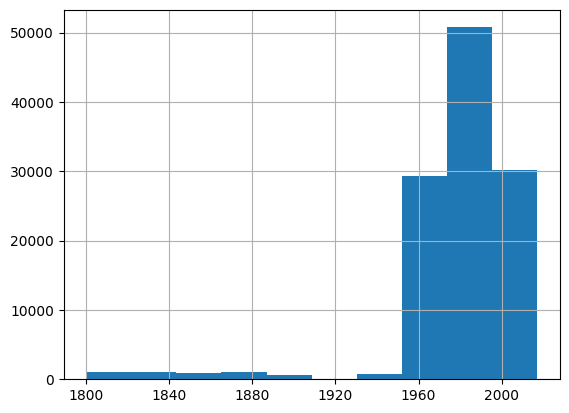

In [14]:
pd.to_datetime(df['Date of Birth'], format='mixed').hist()
plt.show()

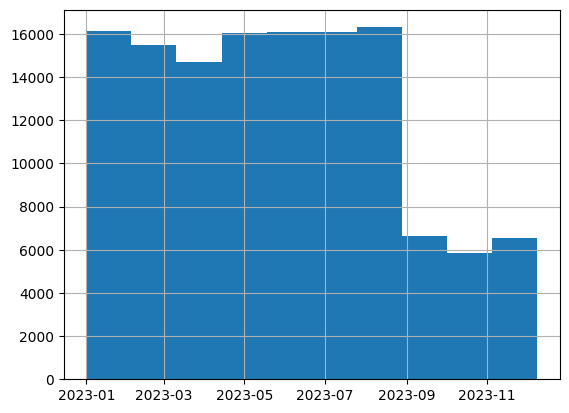

In [15]:
pd.to_datetime(df['Logging'], format='mixed').hist()
plt.show()

In [16]:
df['Date of Birth'] = pd.to_datetime(df['Date of Birth'], format='mixed')
df['Date of Birth'] = df['Date of Birth'].apply(lambda x: x if x.year > 1920 else pd.NaT)

df['Logging'] = pd.to_datetime(df['Logging'], format='mixed')
df['Logging'] = df['Logging'].apply(lambda x: x if x.month < 9 and x.year <= 2023 else pd.NaT)

df[['Date of Birth', 'Logging']].head()

,Date of Birth,Logging
Ext_Intcode,,
BL100AELMIT,1967-02-17,NaT
BL100AQXMUS,2001-06-26,2023-03-23 14:52:00
BL100BAEEDV,NaT,2023-01-29 06:41:00
BL100CNCWCN,1964-10-22,2023-06-22 18:17:00
BL100DHMSHK,2002-09-05,2023-03-23 01:23:00


### 1.8 Data Types
Converting each column to the appropriate data type,

In [17]:
df = df.astype({
    'Gender': 'category', 
    'Date of Birth': 'datetime64[ns]', 
    'Source of Traffic': 'category', 
    'Onboard Wifi Service': 'Int64',
    'Embarkation/Disembarkation time convenient': 'Int64', 
    'Ease of Online booking': 'Int64',
    'Gate location': 'Int64', 
    'Logging': 'datetime64[ns]', 
    'Onboard Dining Service': 'Int64', 
    'Online Check-in': 'Int64',
    'Cabin Comfort': 'Int64', 
    'Onboard Entertainment': 'Int64', 
    'Cabin service': 'Int64',
    'Baggage handling': 'Int64', 
    'Port Check-in Service': 'Int64', 
    'Onboard Service': 'Int64',
    'Cleanliness': 'Int64', 
    'Cruise Name': 'category', 
    'Ticket Type': 'category', 
    'Cruise Distance': 'float64', 
    'WiFi': 'Int64',
    'Dining': 'Int64', 
    'Entertainment': 'Int64',
})

df

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Cruise Name,Ticket Type,Cruise Distance,WiFi,Dining,Entertainment
Ext_Intcode,,,,,,,,,,,,,,,,,,,,,,,
BL100AELMIT,Male,1967-02-17,Direct - Email Marketing,1,1,<NA>,1,NaT,5,5,5,4,4,4,<NA>,4,3,Blastoise,Luxury,150.0,0,1,1
BL100AQXMUS,NaN,2001-06-26,Direct - Company Website,3,5,5,5,2023-03-23 14:52:00,<NA>,<NA>,3,3,4,3,2,3,3,Blastoise,Luxury,1464.0,1,0,1
BL100BAEEDV,Male,NaT,Direct - Email Marketing,<NA>,4,<NA>,1,2023-01-29 06:41:00,<NA>,<NA>,5,5,5,4,3,<NA>,5,Lapras,Standard,1733.0,<NA>,1,<NA>
BL100CNCWCN,Female,1964-10-22,Direct - Company Website,<NA>,<NA>,0,5,2023-06-22 18:17:00,4,5,3,5,5,5,<NA>,5,1,Blastoise,Luxury,NaN,1,0,0
BL100DHMSHK,Female,2002-09-05,Indirect - Social Media,1,1,1,4,2023-03-23 01:23:00,<NA>,1,3,3,3,4,3,<NA>,3,Blastoise,Standard,862.0,<NA>,1,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LB999YYTHAL,Male,1995-07-03,Direct - Company Website,1,<NA>,1,1,NaT,3,1,3,3,3,4,<NA>,4,3,Lapras,Standard,1069.0,<NA>,1,<NA>
LB999ZAGTFL,Female,1994-12-28,Direct - Company Website,1,1,1,1,NaT,5,5,5,5,4,<NA>,3,4,5,Lapras,Luxury,3601.0,1,0,1
LB999ZJGUVX,NaN,1976-09-08,Direct - Email Marketing,4,3,5,2,NaT,3,5,3,3,<NA>,3,<NA>,3,<NA>,Blastoise,Standard,2182.0,<NA>,0,<NA>


### 1.9 Replicate in Data Pipeline
We replicated this data cleaning into the data pipeline that will be used in production.  
We can test that it was replicated exactly here.  

In [18]:
dpl = src.datapipeline.Datapipeline()
dpl.read_data("data/cruise_pre.db", "data/cruise_post.db").equals(df)

True

## 2. Exploratory Data Analysis
We'll try to glean some insights manually from the dataset
- `WiFi` and `Entertainment` has many null values, at a little under half of responses being null.

In [19]:
df.describe(include='all')

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Cruise Name,Ticket Type,Cruise Distance,WiFi,Dining,Entertainment
count,116781,110935,129850,110926.0,114652.0,112063.0,113209.0,112749,113509.0,114634.0,113494.0,114403.0,116396.0,113453.0,115904.0,112099.0,115344.0,114404,110899,107181.000000,62139.0,129850.0,71549.0
unique,2,NaN,4,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2,3,NaN,<NA>,<NA>,<NA>
top,Female,NaN,Direct - Company Website,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Blastoise,Luxury,NaN,<NA>,<NA>,<NA>
freq,59175,NaN,53049,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,75741,53088,NaN,<NA>,<NA>,<NA>
mean,NaN,1984-01-28 01:44:28.838509056,NaN,2.813038,3.05583,2.757369,2.978756,2023-05-03 10:46:33.367213824,3.206442,3.249935,3.439574,3.357884,3.383209,3.633416,3.307064,3.641299,3.285745,NaN,NaN,1266.584019,0.500587,0.499345,0.502621
min,NaN,1938-01-10 00:00:00,NaN,1.0,0.0,0.0,0.0,2023-01-01 00:00:00,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,31.000000,0.0,0.0,0.0
25%,NaN,1972-07-26 00:00:00,NaN,2.0,2.0,2.0,2.0,2023-03-02 13:51:00,2.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,2.0,NaN,NaN,432.000000,0.0,0.0,0.0
50%,NaN,1983-09-18 00:00:00,NaN,3.0,3.0,3.0,3.0,2023-05-02 04:53:00,3.0,3.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0,NaN,NaN,872.000000,1.0,0.0,1.0
75%,NaN,1996-06-18 00:00:00,NaN,4.0,4.0,4.0,4.0,2023-07-02 10:42:00,4.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,4.0,NaN,NaN,1815.000000,1.0,1.0,1.0
max,NaN,2016-12-28 00:00:00,NaN,5.0,5.0,5.0,5.0,2023-08-31 23:44:00,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN,NaN,7987.154420,1.0,1.0,1.0
